In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange # 用于拉格朗日插值
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns # 用于更美观的图表 (可选)

# 设置 matplotlib 支持中文显示 (如果需要)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [2]:
# 1.1 读取数据
try:
    df = pd.read_excel("实验三.xlsx")
except FileNotFoundError:
    print("错误：找不到 '实验三.xlsx' 文件。请确保文件路径正确。")
    exit()

# 打印数据前几行和基本信息，初步了解数据
print("原始数据前5行:")
print(df.head())
print("\n原始数据信息:")
df.info()

# 1.2 检查时间序列完整性 (假设日期和小时列构成了时间序列)
# 首先，将日期和小时合并成一个datetime对象，方便处理
# 注意：小时列的0.5代表00:30，1.5代表01:30，以此类推。我们需要将其转换为标准时间格式。
df['标准小时'] = (df['小时'] - 0.5).astype(int)
df['分钟'] = ((df['小时'] - df['标准小时']) * 60).astype(int)

# 将字符串日期转换为datetime对象
df['日期'] = pd.to_datetime(df['日期'])
df['时间戳'] = df.apply(lambda row: row['日期'] + pd.Timedelta(hours=row['标准小时'], minutes=row['分钟']), axis=1)

# 将'时间戳'设置为索引，方便时间序列分析
df.set_index('时间戳', inplace=True)

# 检查是否有序且无间隔 (这里假设数据是半小时间隔)
# 创建一个完整的时间序列作为参考
expected_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')
missing_timestamps = expected_index.difference(df.index)
if not missing_timestamps.empty:
    print(f"\n警告：时间序列存在缺失的时间点，共 {len(missing_timestamps)} 个。")
    # 可以选择将缺失的时间点加入DataFrame，后续用插值填充
    # df = df.reindex(expected_index) # 重新索引，缺失行会是NaN
else:
    print("\n时间序列完整性检查通过，没有明显的时间点间隔。")


# 1.3 处理缺失值
print(f"\n处理前各列缺失值数量:\n{df.isnull().sum()}")

# 选择需要进行插值的列 (数值型特征列)
# 假设所有数值列都需要检查，除了我们刚刚创建的辅助列和原始日期/小时列
numeric_cols_to_interpolate = ['干球温度', '露点温度', '湿球温度', '湿度', '电价', '电力负荷']

for col in numeric_cols_to_interpolate:
    if df[col].isnull().any():
        print(f"\n对列 '{col}' 进行拉格朗日插值处理...")
        # 拉格朗日插值通常适用于少量连续缺失值
        # Pandas的interpolate方法提供了多种插值方式，包括基于索引的线性、多项式等。
        # 对于拉格朗日插值，如果缺失较多或非连续，需要自定义或寻找特定库。
        # 这里我们使用一个简化的处理方式，如果 scipy.interpolate.lagrange 需要围绕缺失点取值，
        # 则需要先识别NaN的位置，然后取其前后非NaN值进行插值。
        # Pandas 的 interpolate(method='polynomial', order=k) 可以实现多项式插值。
        # 如果严格要求拉格朗日，且缺失值分散，可能需要手动实现或分段插值。

        # 简单起见，我们这里使用pandas的线性插值作为示例，您可以根据需求替换为严格的拉格朗日插值实现
        # df[col] = df[col].interpolate(method='linear')

        # 注意：scipy.interpolate.lagrange 的使用方式是传入已知的x和y点，然后对新的x点进行预测。
        # 在DataFrame中直接应用比较复杂。通常我们会对小的缺失窗口进行操作。
        # 一个更实用的方法是使用 pandas 的 interpolate(method='polynomial', order=...)
        # 或者，如果缺失值是孤立的，可以前后取几个点进行拉格朗日。

        # 示例：如果缺失值不多，可以考虑向前或向后填充，或者线性插值
        # 为了演示，我们这里使用线性插值，因为它更直接且常用。
        # 如果坚持用拉格朗日，您需要编写更复杂的逻辑来选取插值点。
        nan_indices = df[df[col].isnull()].index
        for nan_idx in nan_indices:
            # 寻找nan_idx前后的非空值点，例如各取3个点
            valid_points_before = df[col][:nan_idx].dropna().tail(3)
            valid_points_after = df[col][nan_idx:].dropna().head(3)

            if not valid_points_before.empty and not valid_points_after.empty:
                x_known = np.concatenate([valid_points_before.index.astype(np.int64) // 10**9,
                                          valid_points_after.index.astype(np.int64) // 10**9])
                y_known = np.concatenate([valid_points_before.values, valid_points_after.values])

                # 确保x_known中的值是唯一的，lagrange函数要求x值唯一
                unique_x_known, unique_indices = np.unique(x_known, return_index=True)
                unique_y_known = y_known[unique_indices]

                if len(unique_x_known) > 1: # 拉格朗日插值至少需要2个点
                    poly = lagrange(unique_x_known, unique_y_known)
                    interpolated_value = poly(nan_idx.astype(np.int64) // 10**9)
                    df.loc[nan_idx, col] = interpolated_value
                else:
                    # 如果可用点不足，则使用线性插值或其他方法
                    df[col] = df[col].interpolate(method='linear', limit_direction='both')
                    print(f"警告：列 '{col}' 在索引 {nan_idx} 附近可用点不足以进行拉格朗日插值，已尝试线性插值。")
                    break # 跳出内层循环，因为线性插值会填充所有该列的NaN
            else:
                # 如果前后都找不到足够的点，也使用线性插值
                df[col] = df[col].interpolate(method='linear', limit_direction='both')
                print(f"警告：列 '{col}' 在索引 {nan_idx} 附近找不到足够的点进行拉格朗日插值，已尝试线性插值。")
                break # 跳出内层循环

# 再次检查缺失值
print(f"\n插值处理后各列缺失值数量:\n{df.isnull().sum()}")
# 如果仍有缺失值，可能需要更复杂的处理或考虑删除这些行/列
df.dropna(inplace=True) # 简单起见，删除仍有NaN的行
print(f"\n删除无法插值的行后，数据形状: {df.shape}")


# 1.4 检查并处理重复值 (基于整个行)
duplicate_rows = df.duplicated()
if duplicate_rows.any():
    print(f"\n发现 {duplicate_rows.sum()} 个重复行。")
    df.drop_duplicates(inplace=True)
    print(f"删除重复行后，数据形状: {df.shape}")
else:
    print("\n未发现重复行。")


# 1.5 新增一列保存日类型属性
# 日类型：工作日 (0), 周末 (1), 节假日 (2) - 您需要一个节假日列表
# 这里简化处理，仅区分工作日和周末
df['星期几'] = df.index.dayofweek # Monday=0, Sunday=6
df['日类型'] = df['星期几'].apply(lambda x: 1 if x >= 5 else 0) # 0: 工作日, 1: 周末

# 如果您有节假日数据，可以进一步细化。例如:
# holidays = ['2006-01-01', '2006-05-01', ...] # 示例节假日列表 (字符串格式)
# holidays_date = pd.to_datetime(holidays).date
# df['日类型'] = df.index.date.astype(str).apply(lambda x: 2 if x in holidays_date else (1 if pd.to_datetime(x).dayofweek >= 5 else 0))
# 注意：上面的节假日处理方式效率较低，对于大数据集，建议使用更高效的方法。

print("\n增加日类型后的数据前5行:")
print(df[['星期几', '日类型', '干球温度', '电力负荷']].head())

# 清理不再需要的辅助列
if '标准小时' in df.columns:
    df.drop(columns=['日期', '小时', '标准小时', '分钟', '星期几'], inplace=True)
else: # 如果 '时间戳' 不是索引
    df.drop(columns=['小时', '分钟', '星期几'], inplace=True)


print("\n预处理完成后的数据信息:")
df.info()
print("\n预处理完成后的数据前5行:")
print(df.head())

原始数据前5行:
          日期   小时  干球温度   露点温度   湿球温度    湿度     电价        电力负荷
0 2006-01-01  0.5  23.9  21.65  22.40  87.5  19.67  8013.27833
1 2006-01-01  1.0  23.9  21.70  22.40  88.0  18.56  7726.89167
2 2006-01-01  1.5  23.8  21.65  22.35  88.0  19.09  7372.85833
3 2006-01-01  2.0  23.7  21.60  22.30  88.0  17.40  7071.83333
4 2006-01-01  2.5  23.7  21.60  22.30  88.0  17.00  6865.44000

原始数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      87648 non-null  datetime64[ns]
 1   小时      87648 non-null  float64       
 2   干球温度    87648 non-null  float64       
 3   露点温度    87648 non-null  float64       
 4   湿球温度    87648 non-null  float64       
 5   湿度      87648 non-null  float64       
 6   电价      87648 non-null  float64       
 7   电力负荷    87648 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 5.3 

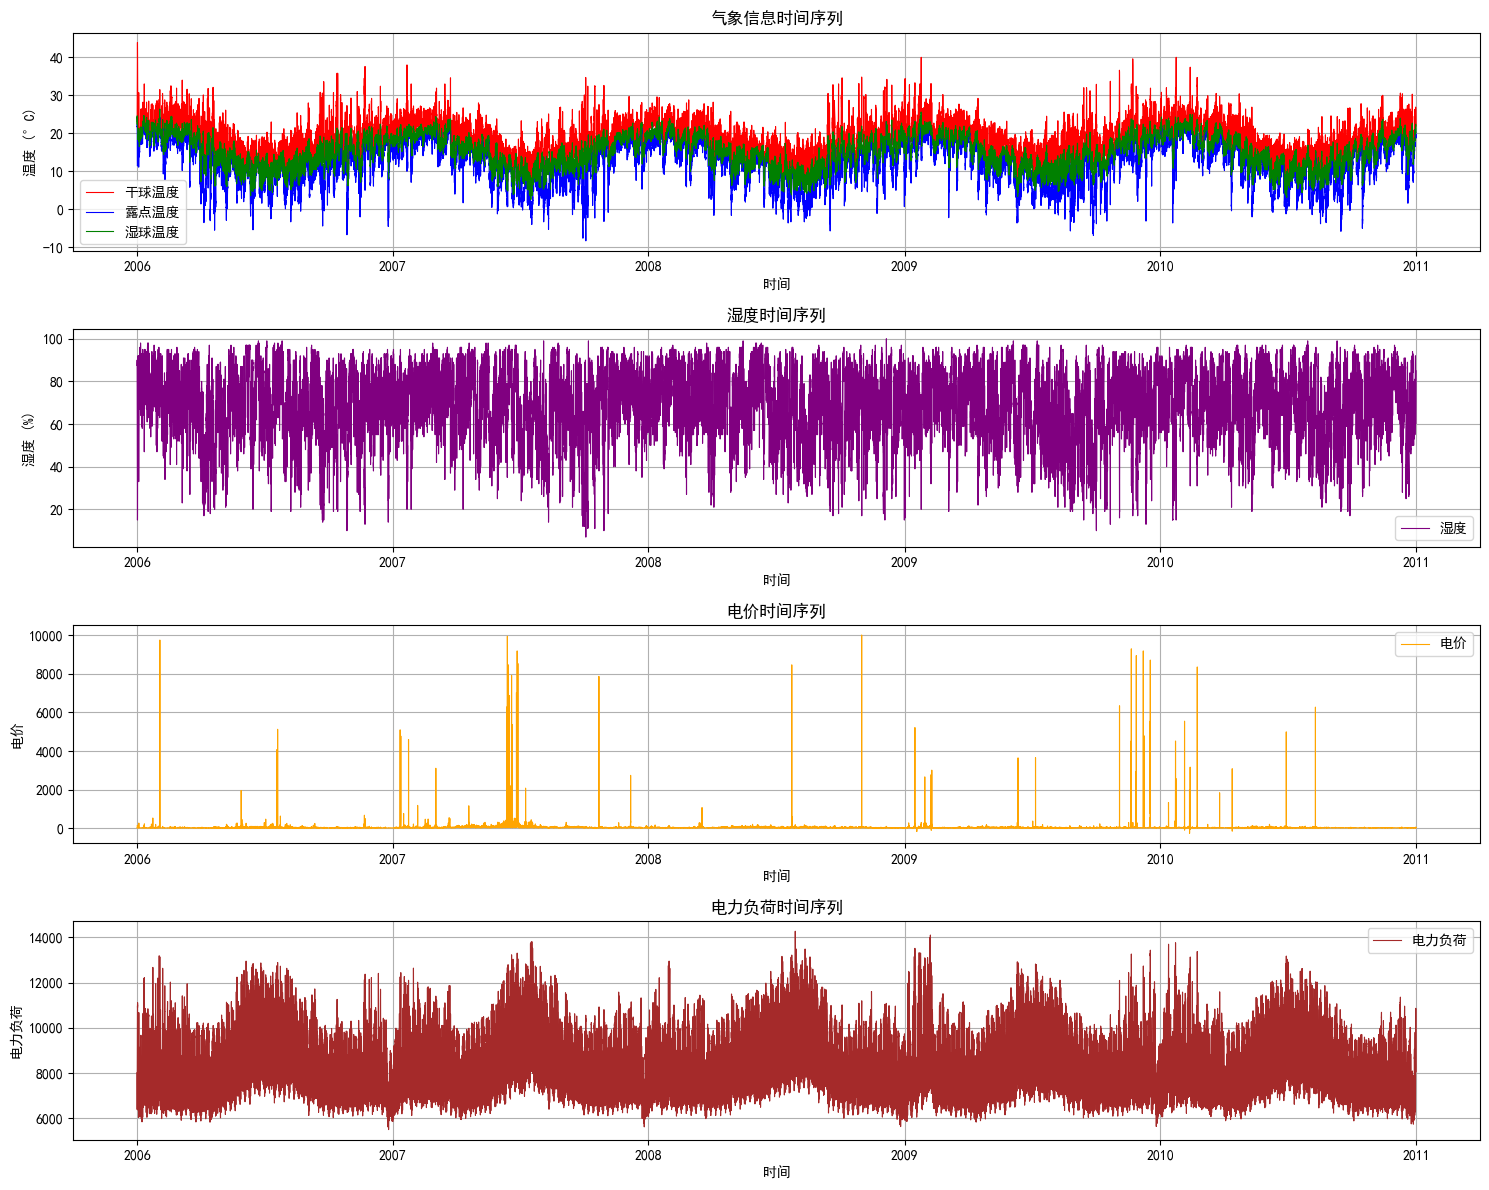

In [3]:
# 2. 数据可视化
plt.figure(figsize=(15, 12))

# 气象信息
plt.subplot(4, 1, 1)
plt.plot(df.index, df['干球温度'], label='干球温度', color='red', linewidth=0.8)
plt.plot(df.index, df['露点温度'], label='露点温度', color='blue', linewidth=0.8)
plt.plot(df.index, df['湿球温度'], label='湿球温度', color='green', linewidth=0.8)
plt.title('气象信息时间序列')
plt.xlabel('时间')
plt.ylabel('温度 (°C)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(df.index, df['湿度'], label='湿度', color='purple', linewidth=0.8)
plt.title('湿度时间序列')
plt.xlabel('时间')
plt.ylabel('湿度 (%)')
plt.legend()
plt.grid(True)

# 电价
plt.subplot(4, 1, 3)
plt.plot(df.index, df['电价'], label='电价', color='orange', linewidth=0.8)
plt.title('电价时间序列')
plt.xlabel('时间')
plt.ylabel('电价')
plt.legend()
plt.grid(True)

# 电力负荷
plt.subplot(4, 1, 4)
plt.plot(df.index, df['电力负荷'], label='电力负荷', color='brown', linewidth=0.8)
plt.title('电力负荷时间序列')
plt.xlabel('时间')
plt.ylabel('电力负荷')
plt.legend()
plt.grid(True)

plt.tight_layout() # 调整子图布局，防止重叠
plt.show()

# 可以单独绘制每个变量，或者使用更灵活的绘图方式
# 例如，绘制电力负荷和最有影响的几个气象因素在一个图上


各属性与电力负荷的相关系数:
电力负荷    1.000000
电价      0.156096
干球温度    0.097593
湿球温度   -0.024693
露点温度   -0.110514
日类型    -0.270441
湿度     -0.271265
Name: 电力负荷, dtype: float64

与电力负荷相关性最高的三个特征: ['湿度', '日类型', '电价']


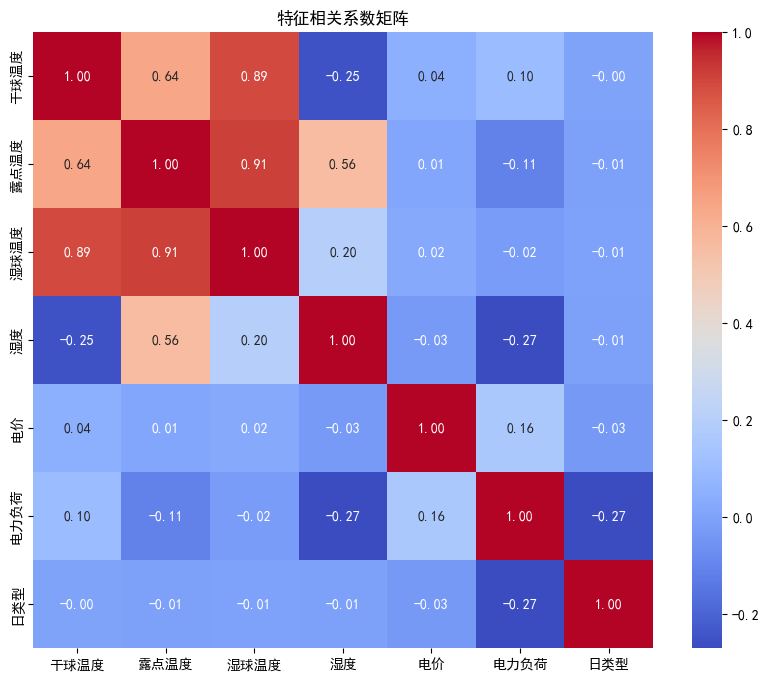

In [4]:
# 3. 相关系数
# 计算所有数值列与'电力负荷'的相关系数
# 确保所有参与计算的列都是数值类型
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if '电力负荷' not in numerical_features:
    print("错误：'电力负荷'列不是数值类型或不存在。")
    exit()

correlations = df[numerical_features].corr()['电力负荷'].sort_values(ascending=False)
print("\n各属性与电力负荷的相关系数:")
print(correlations)

# 选择相关系数绝对值前3高的属性 (排除电力负荷本身)
# 先取绝对值，再排序，然后排除自身
abs_correlations = correlations.abs().drop('电力负荷') # 排除自身
top_3_features = abs_correlations.nlargest(3).index.tolist()

print(f"\n与电力负荷相关性最高的三个特征: {top_3_features}")

# 可视化相关系数矩阵 (可选)
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('特征相关系数矩阵')
plt.show()

In [5]:
# 4. 数据分析

# 4.1 定义输入特征 (X) 和输出目标 (y)
X = df[top_3_features]
y = df['电力负荷']

print("\n选择的特征 (X) 前5行:")
print(X.head())
print("\n目标变量 (y) 前5行:")
print(y.head())

# 4.2 合理划分训练集与测试集
# 通常比例为 70-30 或 80-20。shuffle=False 对于时间序列数据可能更合适，以防止数据泄露。
# 但如果数据没有很强的时序依赖性（例如，已经包含了时间特征如日类型、小时等），可以shuffle。
# 这里我们假设可以打乱，如果不行，设置 shuffle=False，并确保测试集是未来的数据。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\n训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")


# 4.3 选择适合的超参数并建立决策树模型
# 决策树的超参数可以包括：
# - max_depth: 树的最大深度
# - min_samples_split: 分裂内部节点所需的最小样本数
# - min_samples_leaf: 叶节点所需的最小样本数
# - criterion: 'mse' (均方误差) 或 'mae' (平均绝对误差) for regression (sklearn默认是 'mse'，现在是 'squared_error')

# 可以通过网格搜索 (GridSearchCV) 或随机搜索 (RandomizedSearchCV) 来寻找最优超参数
# 这里我们先用一组经验值或默认值
dt_regressor = DecisionTreeRegressor(
    max_depth=10,          # 示例值，可以调整
    min_samples_split=20,  # 示例值，可以调整
    min_samples_leaf=10,   # 示例值，可以调整
    random_state=42,
    criterion='squared_error' # 'mse' 在新版本中为 'squared_error'
)

# 训练模型
print("\n开始训练决策树模型...")
dt_regressor.fit(X_train, y_train)
print("模型训练完成。")


选择的特征 (X) 前5行:
                       湿度  日类型     电价
时间戳                                  
2006-01-01 00:30:00  87.5    1  19.67
2006-01-01 01:00:00  88.0    1  18.56
2006-01-01 01:30:00  88.0    1  19.09
2006-01-01 02:00:00  88.0    1  17.40
2006-01-01 02:30:00  88.0    1  17.00

目标变量 (y) 前5行:
时间戳
2006-01-01 00:30:00    8013.27833
2006-01-01 01:00:00    7726.89167
2006-01-01 01:30:00    7372.85833
2006-01-01 02:00:00    7071.83333
2006-01-01 02:30:00    6865.44000
Name: 电力负荷, dtype: float64

训练集大小: X_train: (70118, 3), y_train: (70118,)
测试集大小: X_test: (17530, 3), y_test: (17530,)

开始训练决策树模型...
模型训练完成。



决策树模型在测试集上的评价:
  均方误差 (MSE): 822955.7347
  均方根误差 (RMSE): 907.1691
  平均绝对误差 (MAE): 700.0575
  R^2 分数: 0.5931


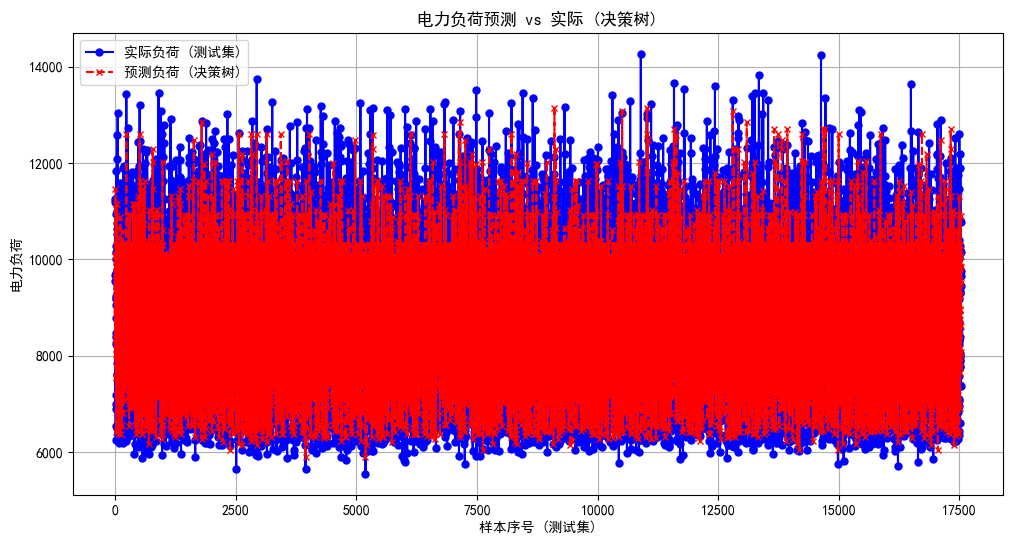

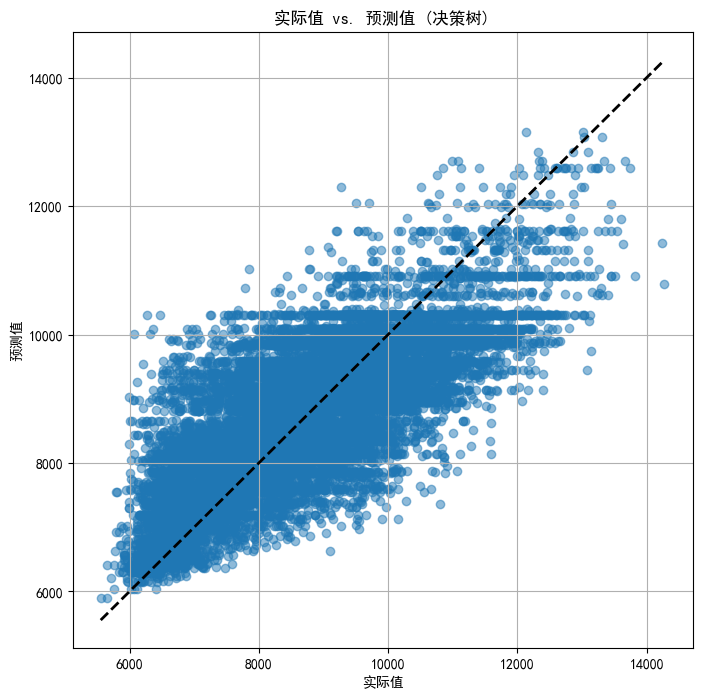

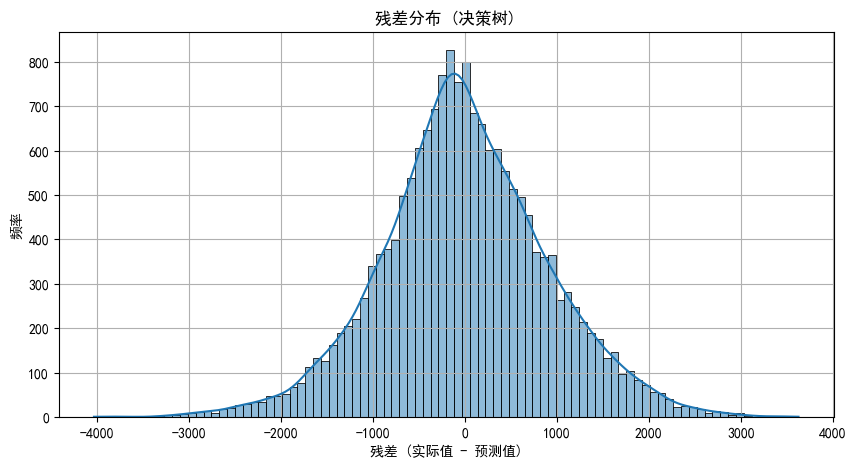


决策树模型特征重要性:
    特征       重要性
2   电价  0.875044
0   湿度  0.070761
1  日类型  0.054195


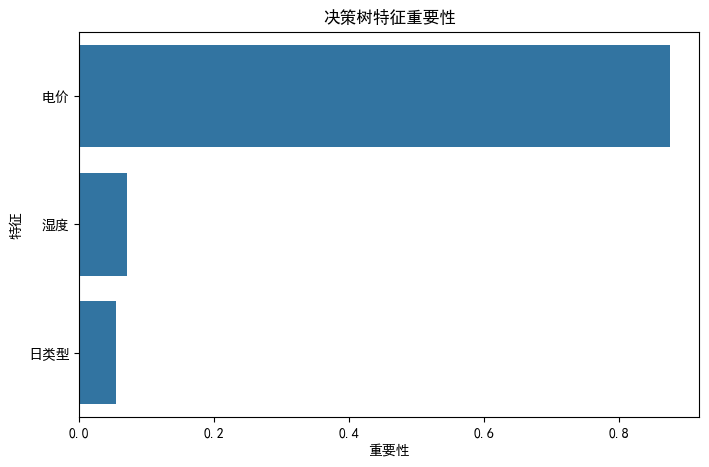

In [6]:
# 5. 模型评价

# 5.1 在测试集上进行预测
y_pred_dt = dt_regressor.predict(X_test)

# 5.2 评价指标
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt) # R-squared 决定系数

print("\n决策树模型在测试集上的评价:")
print(f"  均方误差 (MSE): {mse_dt:.4f}")
print(f"  均方根误差 (RMSE): {rmse_dt:.4f}")
print(f"  平均绝对误差 (MAE): {mae_dt:.4f}")
print(f"  R^2 分数: {r2_dt:.4f}")

# 可视化预测结果与真实值对比
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, color='blue', marker='o', linestyle='-', markersize=5, label='实际负荷 (测试集)')
plt.plot(range(len(y_pred_dt)), y_pred_dt, color='red', marker='x', linestyle='--', markersize=5, label='预测负荷 (决策树)')
plt.title('电力负荷预测 vs 实际 (决策树)')
plt.xlabel('样本序号 (测试集)')
plt.ylabel('电力负荷')
plt.legend()
plt.grid(True)
plt.show()

# 绘制散点图比较实际值和预测值
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # 对角线
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('实际值 vs. 预测值 (决策树)')
plt.grid(True)
plt.show()

# (可选) 残差分析
residuals = y_test - y_pred_dt
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('残差分布 (决策树)')
plt.xlabel('残差 (实际值 - 预测值)')
plt.ylabel('频率')
plt.grid(True)
plt.show()

# 可以考虑输出特征重要性 (如果需要分析哪些特征对决策树影响最大)
if hasattr(dt_regressor, 'feature_importances_'):
    importances = dt_regressor.feature_importances_
    feature_importance_df = pd.DataFrame({'特征': X.columns, '重要性': importances})
    feature_importance_df = feature_importance_df.sort_values(by='重要性', ascending=False)
    print("\n决策树模型特征重要性:")
    print(feature_importance_df)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='重要性', y='特征', data=feature_importance_df)
    plt.title('决策树特征重要性')
    plt.show()